# Figures

In [1]:
import numpy as np
import pandas as pd
from plotnine import *

First, read in neutralization data from Figure 2D of [Kuzmina et al](10.1016/j.chom.2021.03.008) for our viruses of interest (unmutated, K417N, E484K, and K417N-E484K).

In [2]:
neut_data = pd.read_csv('data/kuzmina2021fig2d.csv')
neut_data = neut_data.assign(
    virus = pd.Categorical(
        neut_data['virus'], [' WT', ' K417N', ' E484K', ' K417N-E484K']
    )
)
neut_data.head()

,Concentration,Neutralization_Percent,virus,replicate,serum
0,-3.003324,96.629328,K417N,1,Kuzmina
1,-3.593239,89.368307,K417N,1,Kuzmina
2,-4.293870,77.083924,K417N,1,Kuzmina
3,-5.133134,-0.750882,K417N,1,Kuzmina
4,-3.003315,96.390095,E484K,1,Kuzmina


We can reproduce their Figure 2D. 

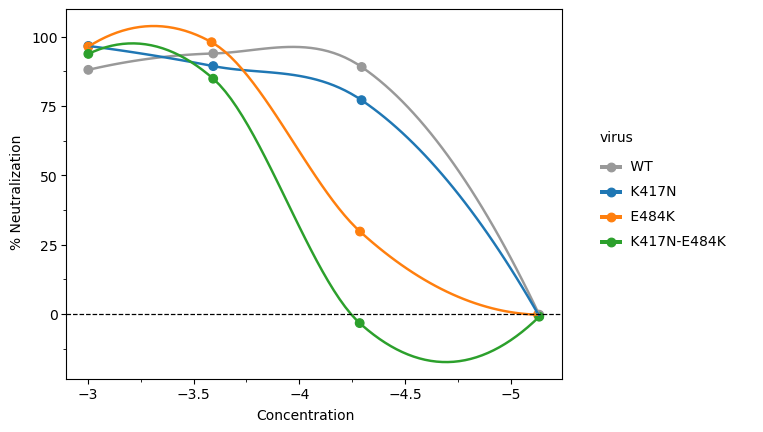

<ggplot: (336817917)>

In [3]:
(
    ggplot(
        neut_data, aes(x='Concentration', 
                       y='Neutralization_Percent',
                       color='virus')
    ) +
    geom_point(size=3) +
    geom_smooth(method='loess', se=False, span=1) +
    geom_hline(yintercept=0, linetype='dashed') +
    scale_x_reverse() +
    scale_color_manual(values=['#999999', '#1f77b4', '#ff7f0e', '#2ca02c']) +
    theme_matplotlib() +
    labs(x='Concentration', y='% Neutralization')
)

Instead of plotting `% neutralization`, we can also plot `fraction infectivity`. To do this, we'll make the following conversion. 

In [4]:
neut_data = neut_data.assign(
    conc = lambda x: [10 ** c for c in x['Concentration']], # not in log space
    f_infect = lambda x: [(100 - n) / 100 for n in x['Neutralization_Percent']]
)
neut_data.head()

,Concentration,Neutralization_Percent,virus,replicate,serum,conc,f_infect
0,-3.003324,96.629328,K417N,1,Kuzmina,0.000992,0.033707
1,-3.593239,89.368307,K417N,1,Kuzmina,0.000255,0.106317
2,-4.293870,77.083924,K417N,1,Kuzmina,0.000051,0.229161
3,-5.133134,-0.750882,K417N,1,Kuzmina,0.000007,1.007509
4,-3.003315,96.390095,E484K,1,Kuzmina,0.000992,0.036099


To plot neutralization, we'll fit Hill curves using `scipy.optimize`.

In [5]:
from scipy.optimize import curve_fit

def objective(c, s, m):
    '''
    objective function for hill curve
    args ---
      c: concentration
      s: slope (hill coefficient)
      m: midpoint of curve
    '''
    return 1 / (1 + (c / m) ** s)

df = pd.DataFrame()
for virus in neut_data['virus'].unique():
    subd = neut_data.query('virus == @virus')
    conc = np.array(subd['conc'])
    frac = np.array(subd['f_infect'])
    
    # curve fitting
    popt, _ = curve_fit(objective, conc, frac)
    
    # manually tune parameters for this virus because the optimal
    # parameters lead to a misleading curve, due to only 4 points
    if virus == ' K417N-E484K':
        popt[0] /= 3
        popt[1] /= 1.4
    
    plot_data = pd.DataFrame(
        {
            'virus' : virus,
            'conc' : np.logspace(-5.2, -3, num=100),
        }
    ).assign(
        f_infect = lambda x: [
            objective(p, 
            popt[0], 
            popt[1]
            ) for p in x['conc']
        ]
    )
    df = pd.concat([df, plot_data])
    
df.head()

/var/folders/tc/rtc4n5693tv8_26p423kkzjm0000gn/T/ipykernel_64806/3127640216.py:11: RuntimeWarning: invalid value encountered in power


,virus,conc,f_infect
0,K417N,0.000006,0.991690
1,K417N,0.000007,0.990391
2,K417N,0.000007,0.988890
3,K417N,0.000007,0.987159
4,K417N,0.000008,0.985162


Plot the neutralization curves.

/opt/anaconda3/envs/polyclonal-paper/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5 x 3.5 in image.
/opt/anaconda3/envs/polyclonal-paper/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/neut_kuzmina2021.pdf


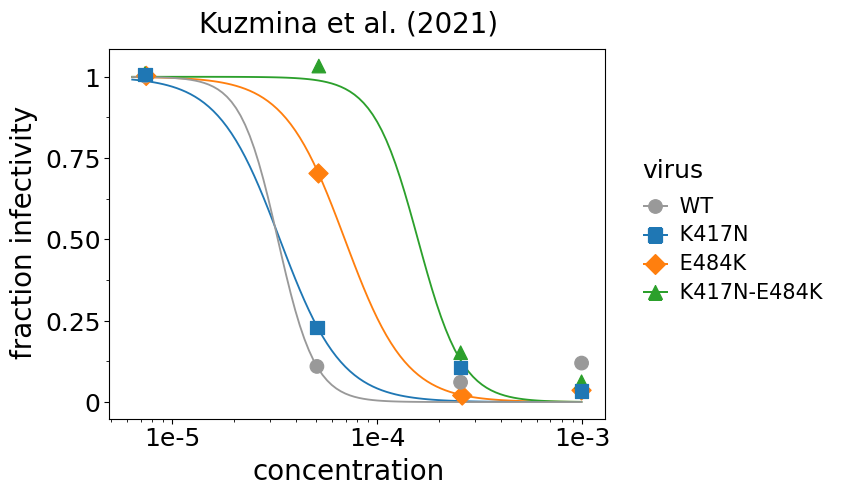

In [6]:
p = (
    ggplot(aes(x='conc', y='f_infect')) + 
    geom_line(df, aes(color='virus'), size=0.75) + 
    geom_point(neut_data, aes(color='virus', shape='virus'), size=5) + 
    scale_x_log10() +
    scale_color_manual(values=['#999999', '#1f77b4', '#ff7f0e', '#2ca02c']) +
    scale_shape_manual(values=['o','s', 'D', '^']) +
    theme_matplotlib() + 
    labs(x='concentration', y='fraction infectivity', title='Kuzmina et al. (2021)') +
    theme(
        plot_title=element_text(size=20),
        axis_title_y=element_text(size=20),
        axis_title_x=element_text(size=20),
        axis_text_y=element_text(size=18),
        axis_text_x=element_text(size=18),
        legend_title=element_text(size=18),
        legend_text=element_text(size=15)
    )
)
p.save('figures/neut_kuzmina2021.pdf', height=3.5, width=5)
p.draw()